In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import OneBall2DFreeFallPredictionFromInitialStateWithDiameterDataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss as mse

from itertools import product
from tqdm.notebook import tqdm_notebook

In [2]:
def calculate_test_loss(model, dataloader, dataset, visualize_first_10_trajectories=True):
    test_loss = (np.sum([mse(model(X), y)*len(y) for X, y in dataloader]) / len(dataset)) ** 0.5
    print('Test loss: ', test_loss)

    if visualize_first_10_trajectories:
        fig1, axs1 = plt.subplots(2, 5, figsize=(20,10))
        fig2, axs2 = plt.subplots(2, 5, figsize=(20,10))

        fig1.suptitle('Y-coordinate over time')
        fig2.suptitle('Trajectory')

        plt.setp(axs1[-1, :], xlabel='Frame number')
        plt.setp(axs1[:, 0], ylabel='Y-coordinate')

        plt.setp(axs2[-1, :], xlabel='X-coordinate')
        plt.setp(axs2[:, 0], ylabel='Y-coordinate')

        for row_id in range(len(axs1)):
            for col_id in range(len(axs1[row_id])):
                # axs1 and axs2 are time series, so only limiting y-axis
                axs1[row_id, col_id].set_ylim(0, 1)

                # axs3 shows trajectories, so limiting both axis
                axs2[row_id, col_id].set_xlim(0, 1)
                axs2[row_id, col_id].set_ylim(0, 1)


        for X, y in dataloader:
            pred = model(X).detach().numpy()

            for count in range(10):
                gr = np.insert(y.squeeze().numpy()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][0:2])
                pr = np.insert(pred.squeeze()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][0:2])

                axs1[int(count >= 5)][count % 5].plot(gr[1::2], label=f'Ground truth')
                axs1[int(count >= 5)][count % 5].plot(pr[1::2], label='Predicted')
                axs1[int(count >= 5)][count % 5].legend()

                axs2[int(count >= 5)][count % 5].plot(gr[0::2], gr[1::2], label=f'Ground truth')
                axs2[int(count >= 5)][count % 5].plot(pr[0::2], pr[1::2], label='Predicted')
                axs2[int(count >= 5)][count % 5].legend()

            break

        plt.show()
    return test_loss

In [19]:
def train_model(model_class, train_dataloader, num_epochs=100, error_threshold=15, epoch_threshold=0.001, learning_rate=0.1, **kwargs):
    model = model_class(**kwargs)
    print(model)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # This array will store the loss values per epoch
    loss_per_epoch = []

    # This variable is needed to calculate the total epoch loss
    epoch_loss = 0

    # Training
    epoch = 0
    while epoch < num_epochs:
        for X, y in train_dataloader:
            # For each data instance we need to reset the optimizer gradients
            optimizer.zero_grad()
            
            pred = model(X)
            loss = loss_fn(pred, y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            
        if epoch_loss > error_threshold:
            print(f'Unsuccessful start. Loss: {epoch_loss}')
            model = model_class(**kwargs)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
            epoch_loss = 0
            continue

        loss_per_epoch.append(epoch_loss)

        
        # Keeping training log
        print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')

        if len(loss_per_epoch) > 1 and loss_per_epoch[-2] - epoch_loss < epoch_threshold:
            print(f'Training stopped on epoch {epoch}')
            break
        
        epoch_loss = 0
        epoch += 1

    return model

In [4]:
batch_size = 32

train_data, test_data = OneBall2DFreeFallPredictionFromInitialStateWithDiameterDataset.train_test_split('../data/raw/single-ball-2d-free-fall-initial-with-diameter', test_frac=0.2)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  10562
train_test_split response: test fraction rounded to 0.19998485250123074 (10562 simulations)


## Vanila RNN

## Single recurrent layer

In [5]:
class VanilaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_rnns, output_dim, dropout_prob=0):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_rnns = num_rnns

        self.rnn = nn.RNN(input_dim, hidden_dim, num_rnns, batch_first=True, dropout=dropout_prob)
        self.out = nn.Linear(hidden_dim, output_dim)
        torch.nn.init.normal_(self.out.weight, 0, 1)

    
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_rnns, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.out(out)
        return out

VanilaRNN(
  (rnn): RNN(3, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=48, bias=True)
)
Epoch 0 complete. Training loss: 7.122329583449755
Epoch 1 complete. Training loss: 0.7289770876232069
Epoch 2 complete. Training loss: 0.625409368716646
Epoch 3 complete. Training loss: 0.595434120594291
Epoch 4 complete. Training loss: 0.5784545096539659
Epoch 5 complete. Training loss: 0.5670272730494617
Epoch 6 complete. Training loss: 0.5588144655775977
Epoch 7 complete. Training loss: 0.5527084468194516
Epoch 8 complete. Training loss: 0.5480695386213483
Epoch 9 complete. Training loss: 0.5444859924464254
Epoch 10 complete. Training loss: 0.5416773723263759
Epoch 11 complete. Training loss: 0.539445486603654
Epoch 12 complete. Training loss: 0.5376464576838771
Epoch 13 complete. Training loss: 0.5361753401666647
Epoch 14 complete. Training loss: 0.5349553327396279
Epoch 15 complete. Training loss: 0.5339287668757606
Epoch 16 complete. Training loss: 0.5330524070159299
Tr

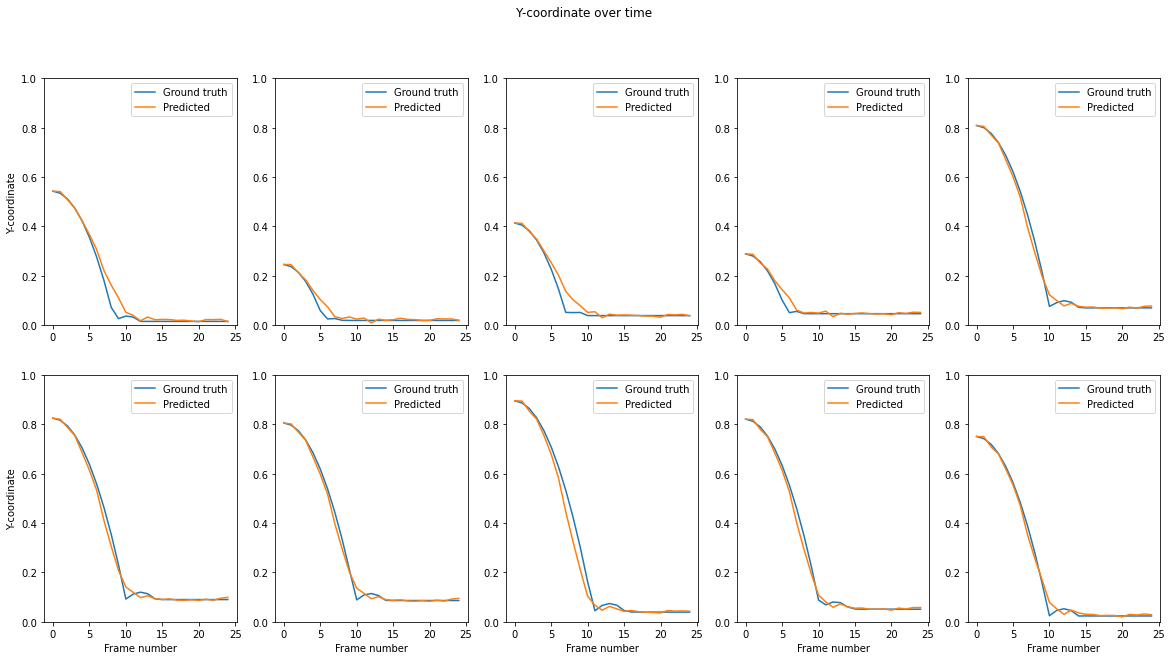

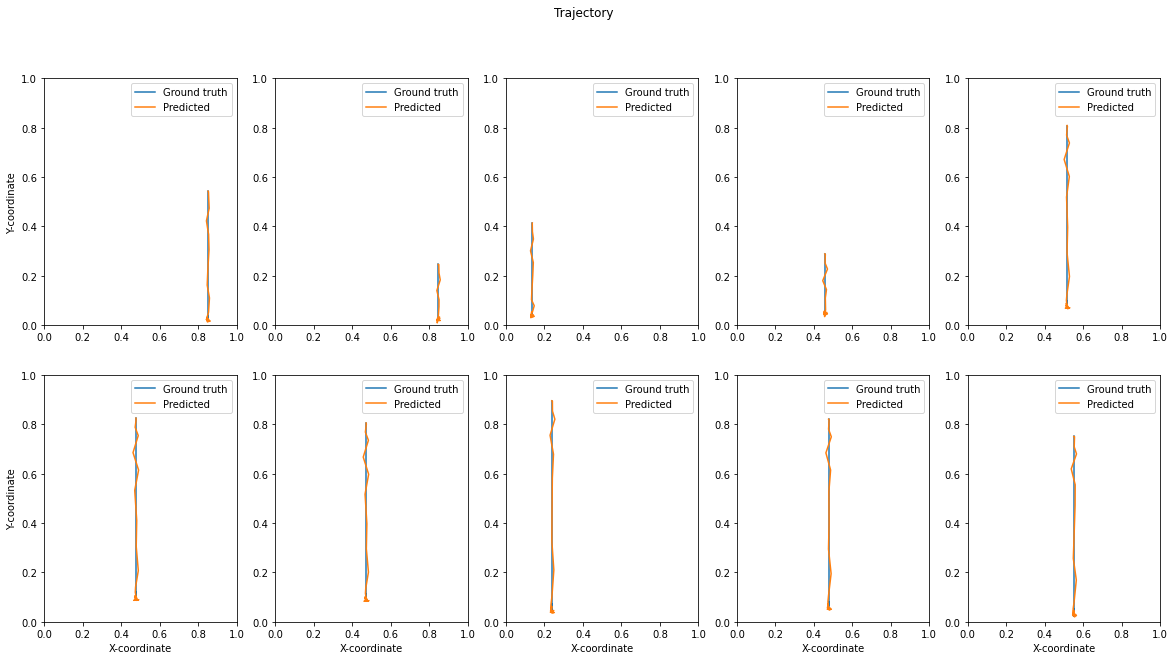

In [10]:
model1 = train_model(VanilaRNN, train_dataloader=train_dataloader, input_dim=3, hidden_dim=64, num_rnns=1, output_dim=48, dropout_prob=0)
test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=True)

### Two recurrent layers

VanilaRNN(
  (rnn): RNN(3, 64, num_layers=2, batch_first=True)
  (out): Linear(in_features=64, out_features=48, bias=True)
)
Unsuccessful start. Loss: 26.3598197530373
Unsuccessful start. Loss: 34.719960789661855
Unsuccessful start. Loss: 66.50491909665288
Unsuccessful start. Loss: 31.49511966580758
Unsuccessful start. Loss: 34.234953361796215
Unsuccessful start. Loss: 493.0737772202119
Unsuccessful start. Loss: 508.8654773067683
Unsuccessful start. Loss: 31.071493416442536
Unsuccessful start. Loss: 25.443585264729336
Unsuccessful start. Loss: 38.515994359215256
Epoch 0 complete. Training loss: 23.31810965051409
Epoch 1 complete. Training loss: 0.7803420696873218
Epoch 2 complete. Training loss: 0.6454243403859437
Epoch 3 complete. Training loss: 0.6111852120666299
Epoch 4 complete. Training loss: 0.5950730882759672
Epoch 5 complete. Training loss: 0.5843347033369355
Epoch 6 complete. Training loss: 0.5759446219308302
Epoch 7 complete. Training loss: 0.5689040861325338
Epoch 8 complete

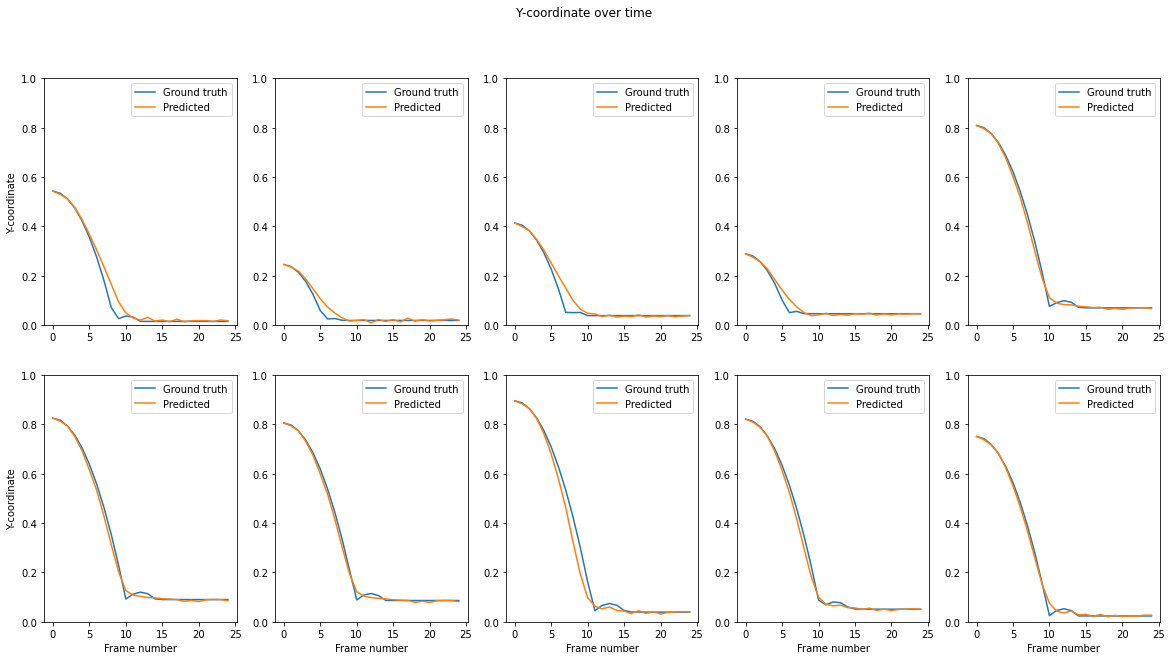

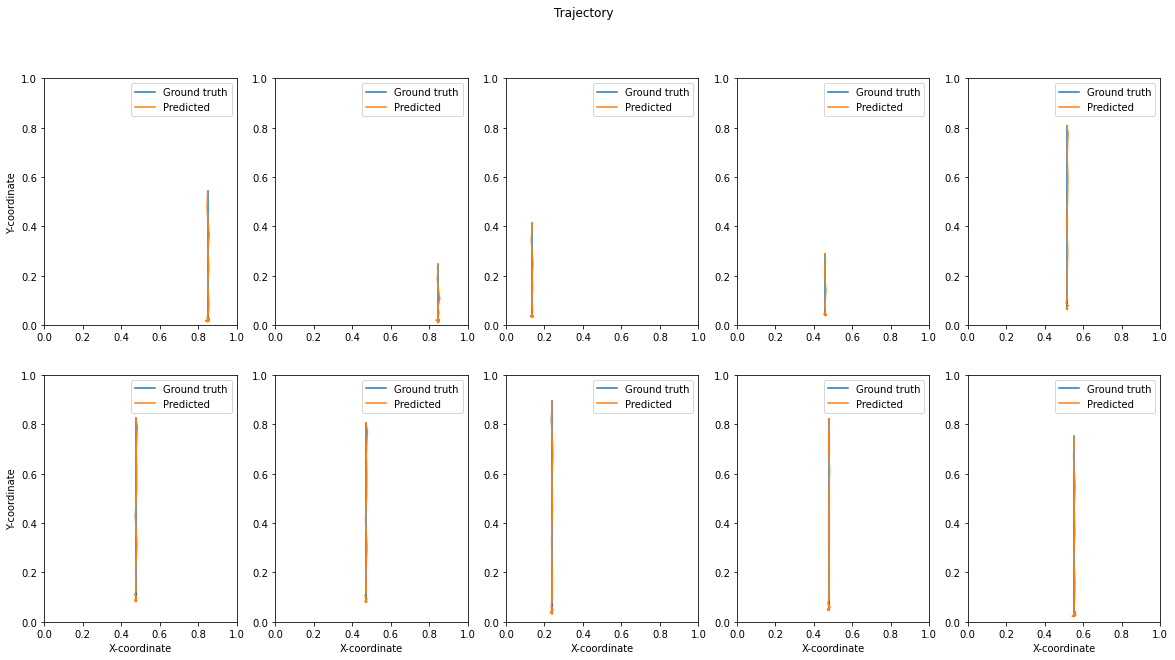

In [12]:
model2 = train_model(VanilaRNN, train_dataloader=train_dataloader, error_threshold=25, input_dim=3, hidden_dim=64, num_rnns=2, output_dim=48, dropout_prob=0)
test_loss = calculate_test_loss(model2, test_dataloader, test_data, visualize_first_10_trajectories=True)

### Two recurrent layers with dropout

VanilaRNN(
  (rnn): RNN(3, 64, num_layers=2, batch_first=True, dropout=0.1)
  (out): Linear(in_features=64, out_features=48, bias=True)
)
Unsuccessful start. Loss: 36.07424705289304
Unsuccessful start. Loss: 31.205918398685753
Epoch 0 complete. Training loss: 21.898656046949327
Epoch 1 complete. Training loss: 3.2296768004307523
Epoch 2 complete. Training loss: 2.417489298270084
Epoch 3 complete. Training loss: 2.036069437279366
Epoch 4 complete. Training loss: 1.7989615657133982
Epoch 5 complete. Training loss: 1.654250438325107
Epoch 6 complete. Training loss: 1.5350669457111508
Epoch 7 complete. Training loss: 1.4587910391855985
Epoch 8 complete. Training loss: 1.3862257941509597
Epoch 9 complete. Training loss: 1.3476235691923648
Epoch 10 complete. Training loss: 1.2959629596443847
Epoch 11 complete. Training loss: 1.269160462601576
Epoch 12 complete. Training loss: 1.2376450131996535
Epoch 13 complete. Training loss: 1.2148604257963598
Epoch 14 complete. Training loss: 1.199753258

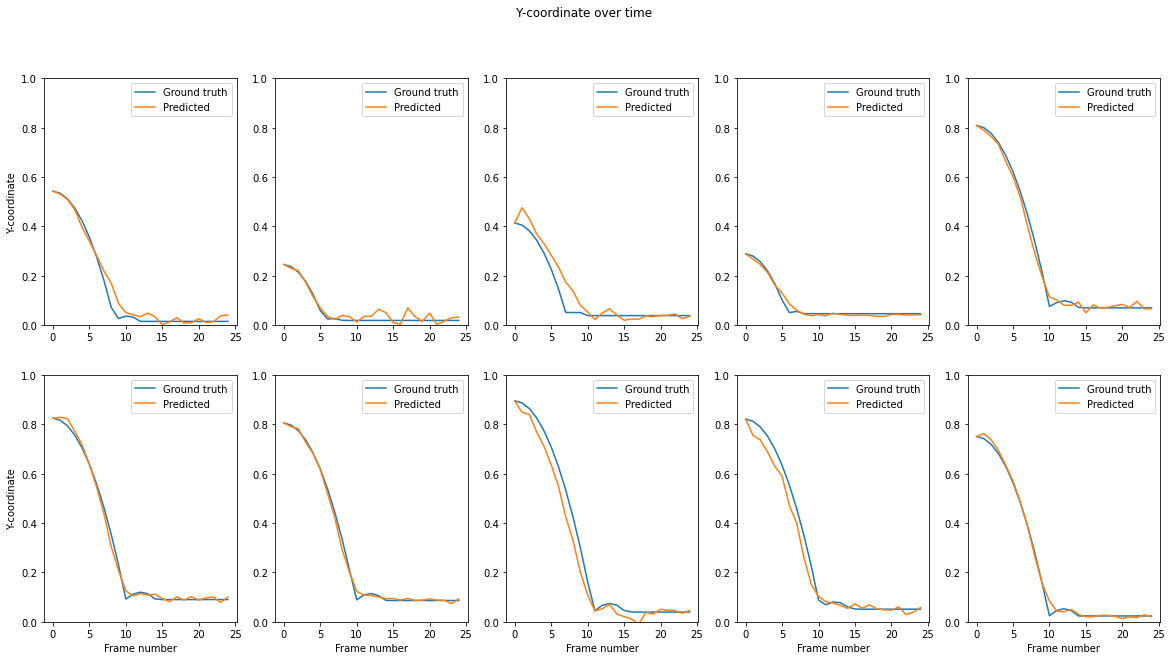

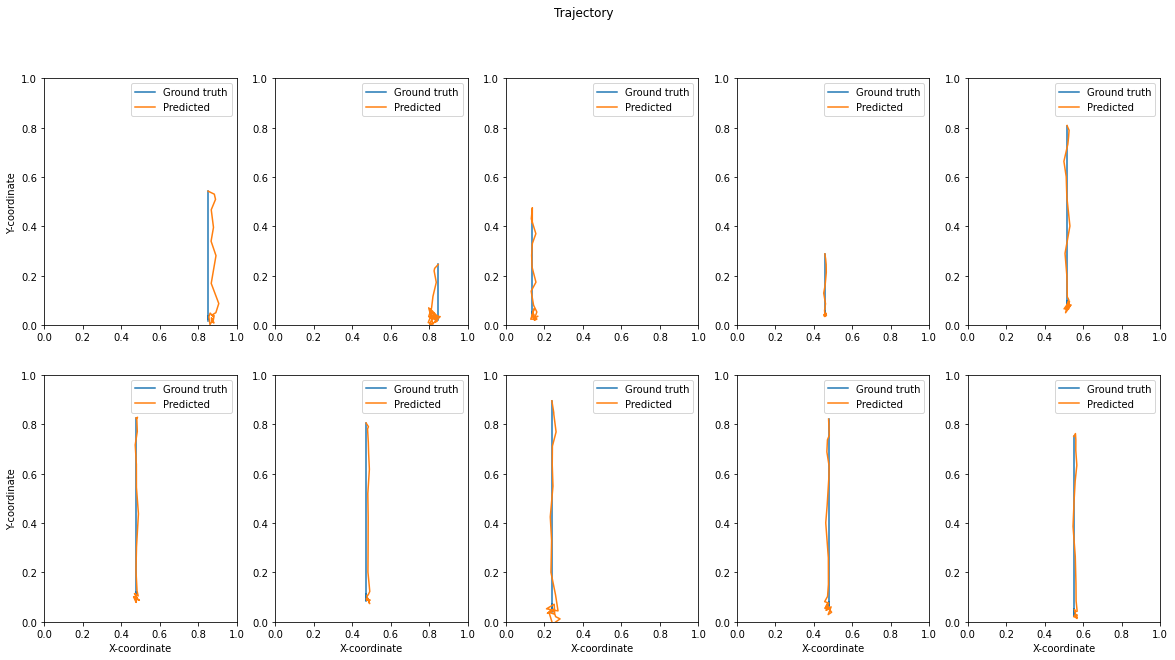

In [13]:
model3 = train_model(VanilaRNN, train_dataloader=train_dataloader, error_threshold=25, input_dim=3, hidden_dim=64, num_rnns=2, output_dim=48, dropout_prob=0.1)
test_loss = calculate_test_loss(model3, test_dataloader, test_data, visualize_first_10_trajectories=True)

## GRU

In [16]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_rnns, output_dim, dropout_prob=0):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_rnns = num_rnns

        self.gru = nn.GRU(input_dim, hidden_dim, num_rnns, batch_first=True, dropout=dropout_prob)
        self.out = nn.Linear(hidden_dim, output_dim)
        torch.nn.init.normal_(self.out.weight, 0, 1)

    
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_rnns, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.gru(x, h0.detach())

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.out(out)
        return out

GRU(
  (gru): GRU(3, 64, num_layers=2, batch_first=True)
  (out): Linear(in_features=64, out_features=48, bias=True)
)
Unsuccessful start. Loss: 25.818041369784623
Unsuccessful start. Loss: 29.968903051689267
Unsuccessful start. Loss: 29.65686318092048
Unsuccessful start. Loss: 27.454549110960215
Unsuccessful start. Loss: 27.373105518054217
Epoch 0 complete. Training loss: 22.813055721577257
Epoch 1 complete. Training loss: 4.36576867219992
Epoch 2 complete. Training loss: 1.8613961125374772
Epoch 3 complete. Training loss: 1.1887377148959786
Epoch 4 complete. Training loss: 0.952758863568306
Epoch 5 complete. Training loss: 0.8467401111556683
Epoch 6 complete. Training loss: 0.7875634603842627
Epoch 7 complete. Training loss: 0.7488940097391605
Epoch 8 complete. Training loss: 0.7207268866768572
Epoch 9 complete. Training loss: 0.6985778972448315
Epoch 10 complete. Training loss: 0.6801960501470603
Epoch 11 complete. Training loss: 0.6643639947287738
Epoch 12 complete. Training loss: 

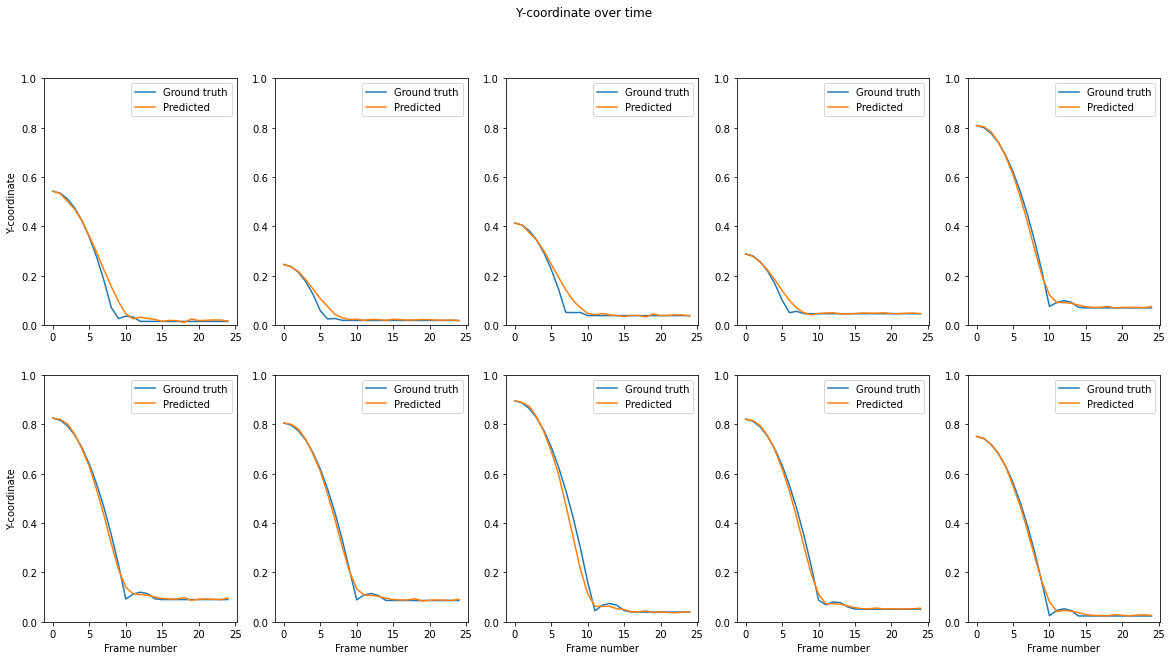

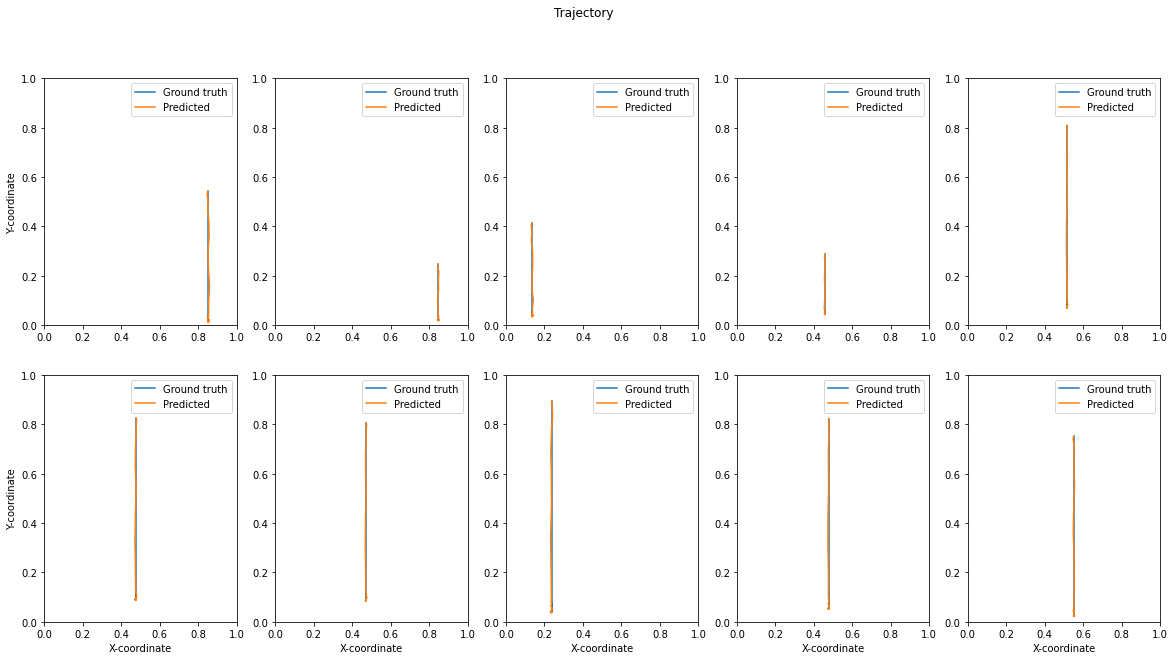

In [36]:
model4 = train_model(GRU, train_dataloader=train_dataloader, error_threshold=25, input_dim=3, hidden_dim=64, num_rnns=2, output_dim=48, dropout_prob=0)
test_loss = calculate_test_loss(model4, test_dataloader, test_data, visualize_first_10_trajectories=True)

## LSTM

In [47]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_rnns, output_dim, dropout_prob=0):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_rnns = num_rnns

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_rnns, batch_first=True, dropout=dropout_prob)
        self.out = nn.Linear(hidden_dim, output_dim)
        torch.nn.init.normal_(self.out.weight, 0, 1)

    
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_rnns, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.num_rnns, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.out(out)
        return out

LSTM(
  (lstm): LSTM(3, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=48, bias=True)
)
Unsuccessful start. Loss: 30.94102340331301
Unsuccessful start. Loss: 29.47839285247028
Unsuccessful start. Loss: 29.21108839288354
Unsuccessful start. Loss: 34.0789177166298
Unsuccessful start. Loss: 27.144323041196913
Unsuccessful start. Loss: 26.604254972655326
Unsuccessful start. Loss: 25.17889067949727
Unsuccessful start. Loss: 31.885201232507825
Epoch 0 complete. Training loss: 24.958559811580926
Epoch 1 complete. Training loss: 6.446374783059582
Epoch 2 complete. Training loss: 3.542544378666207
Epoch 3 complete. Training loss: 2.3697122640442103
Epoch 4 complete. Training loss: 1.7606600621948019
Epoch 5 complete. Training loss: 1.3926745002390817
Epoch 6 complete. Training loss: 1.1513625501538627
Epoch 7 complete. Training loss: 0.9862088056397624
Epoch 8 complete. Training loss: 0.8703891487675719
Epoch 9 complete. Training loss: 0.7877720756805502
Epoch 10 complete. T

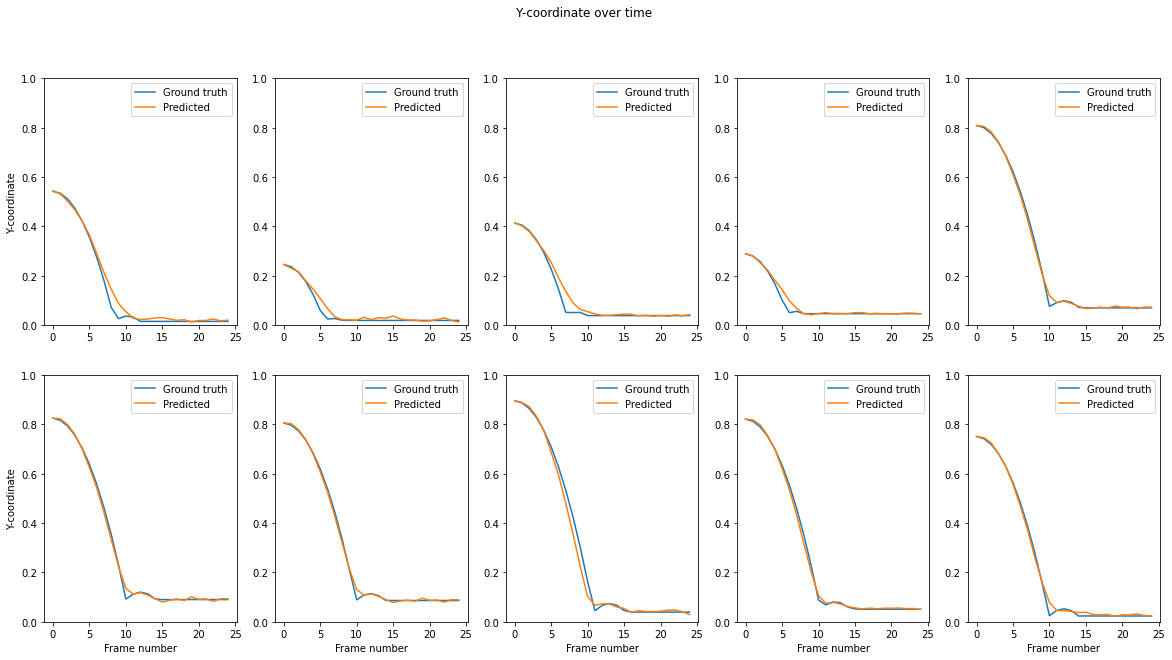

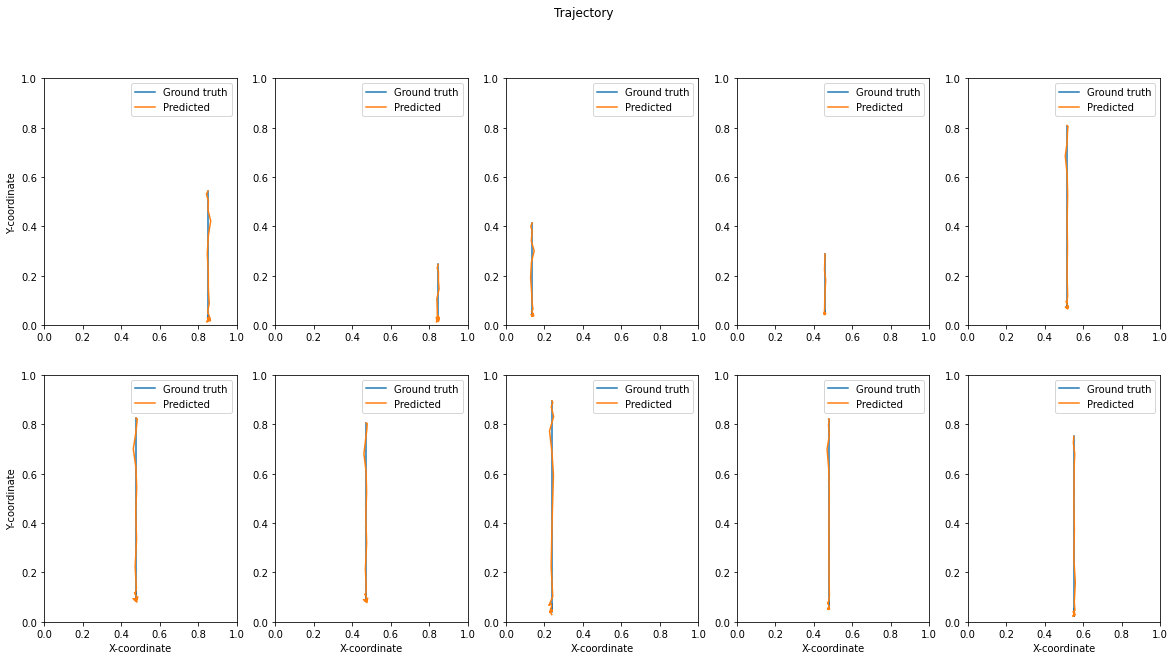

In [48]:
model5 = train_model(LSTM, train_dataloader=train_dataloader, error_threshold=25, input_dim=3, hidden_dim=64, num_rnns=1, output_dim=48, dropout_prob=0)
test_loss = calculate_test_loss(model5, test_dataloader, test_data, visualize_first_10_trajectories=True)